In [1]:
import paramiko
import pickle
import os
import pandas as pd
import zipfile
from datetime import datetime,timedelta
import matplotlib.pylab as plt
pd.set_option('display.max_columns',110)

C:\Users\micha\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
hostname = "sftp.datashop.livevol.com"
port = 22
username = "nan2_lehigh_edu"
password = "PAIndex2023!"
remote_folder = "/subscriptions/order_000046197/item_000053507"
local_folder = os.path.join(os.getcwd(),"input")

In [3]:
def extract_zip(zip_filename, extraction_folder):
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extraction_folder)

In [4]:
start = datetime(2024,5,1)
end = datetime(2024,5,31)

In [5]:
ssh = paramiko.SSHClient()

files_for_report = []
report_data = {}

try:
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())

    ssh.connect(hostname, port, username, password)

    with ssh.open_sftp() as sftp:

        sftp.chdir(remote_folder)

        files = sftp.listdir()

        for file in files:
            if file.startswith("UnderlyingEOD_"):
                try:
                    file_date = datetime.strptime(file.split("_")[-1].split(".")[0], "%Y-%m-%d")
                    if file_date >= start and file_date <= end:
                        files_for_report.append(file)
                except Exception as e:
                    print(f"Error: {e}")

        for file in files_for_report:
            remote_path = os.path.join(remote_folder,file).replace("\\", "/")
            local_path = os.path.join(local_folder,file).replace("\\", "/")

            sftp.get(remote_path, local_path)

            extract_zip(local_path, local_folder)

            os.remove(local_path)

except Exception as e:
    print(f"Error: {e}")

finally:
    ssh.close()

In [6]:
report_data = {}

csv_files = [file for file in os.listdir(local_folder) if file.startswith("UnderlyingEOD_") and file.endswith(".csv")]
sorted_csv_files = sorted(csv_files, key=lambda x: datetime.strptime(x.split("_")[-1].split(".")[0], "%Y-%m-%d"), reverse=False)

if sorted_csv_files != []:
    for csv_file in sorted_csv_files:
        csv_file_path = os.path.join(local_folder, csv_file)
        csv_file_date = csv_file.split("_")[-1].split(".")[0]
        eod_df = pd.read_csv(csv_file_path)
        report_data[csv_file_date] = eod_df
        try:
            os.remove(csv_file_path)
            print(f"Deleted: {csv_file_path}")
        except FileNotFoundError:
            print(f"File not found: {csv_file_path}")
        except Exception as e:
            print(f"Error deleting file: {e}")
else:
    print("No CSV files found in the 'input' folder.")

Deleted: C:\Users\micha\OneDrive\Documents\Projects\PA100\PA-Index\input\UnderlyingEOD_2024-05-03.csv
Deleted: C:\Users\micha\OneDrive\Documents\Projects\PA100\PA-Index\input\UnderlyingEOD_2024-05-06.csv
Deleted: C:\Users\micha\OneDrive\Documents\Projects\PA100\PA-Index\input\UnderlyingEOD_2024-05-07.csv
Deleted: C:\Users\micha\OneDrive\Documents\Projects\PA100\PA-Index\input\UnderlyingEOD_2024-05-08.csv
Deleted: C:\Users\micha\OneDrive\Documents\Projects\PA100\PA-Index\input\UnderlyingEOD_2024-05-09.csv
Deleted: C:\Users\micha\OneDrive\Documents\Projects\PA100\PA-Index\input\UnderlyingEOD_2024-05-10.csv
Deleted: C:\Users\micha\OneDrive\Documents\Projects\PA100\PA-Index\input\UnderlyingEOD_2024-05-13.csv
Deleted: C:\Users\micha\OneDrive\Documents\Projects\PA100\PA-Index\input\UnderlyingEOD_2024-05-14.csv
Deleted: C:\Users\micha\OneDrive\Documents\Projects\PA100\PA-Index\input\UnderlyingEOD_2024-05-15.csv
Deleted: C:\Users\micha\OneDrive\Documents\Projects\PA100\PA-Index\input\Underlyin

In [9]:
import warnings

df = pd.read_excel('input/raycounty.xlsx')
df.columns = df.columns.str.rstrip('\n')
df['Ticker'] = df['Ticker'].str.split(' ',n=1,expand=True)[0].replace(' ','')
float_df = df[['Ticker','Equity Float','County']].head(100)

eod_market_cap_pivot = pd.DataFrame()

unique_dates = list(report_data.keys())

for date in unique_dates:
    
    eod_df = report_data[date]

    merged_df = pd.merge(float_df,eod_df,left_on='Ticker',right_on='underlying_symbol')

    merged_df['Market Cap'] = merged_df['Equity Float'] * merged_df['close']

    merged_df = merged_df[['Ticker','County','quote_date','Market Cap']]
    
    merged_df = merged_df.groupby(['quote_date','County'])['Market Cap'].sum().to_frame().reset_index().set_index('quote_date')

    eod_market_cap_pivot = pd.concat([eod_market_cap_pivot,merged_df])

eod_market_cap_pivot['Return'] = eod_market_cap_pivot.groupby('County')['Market Cap'].transform(lambda x: ((x / x.iloc[0]) - 1) * 100)
eod_market_cap_pivot = eod_market_cap_pivot.rename_axis(index='Date')
eod_market_cap_pivot.index = pd.to_datetime(eod_market_cap_pivot.index,errors='coerce')
eod_market_cap_pivot = eod_market_cap_pivot.reset_index()
eod_market_cap_pivot

,Date,County,Market Cap,Return
0,2024-05-03,Allegheny,2.656079e+11,0.000000
1,2024-05-03,Berks,1.825156e+10,0.000000
2,2024-05-03,Bucks,1.449192e+10,0.000000
3,2024-05-03,Butler,1.523893e+10,0.000000
4,2024-05-03,Chester,1.016496e+11,0.000000
...,...,...,...,...
395,2024-05-31,Philadelphia,2.178075e+11,3.005796
396,2024-05-31,Susquehanna,2.508892e+08,-1.362948
397,2024-05-31,Warren,1.374319e+09,-0.994575
398,2024-05-31,Washington,4.669735e+10,-1.320183


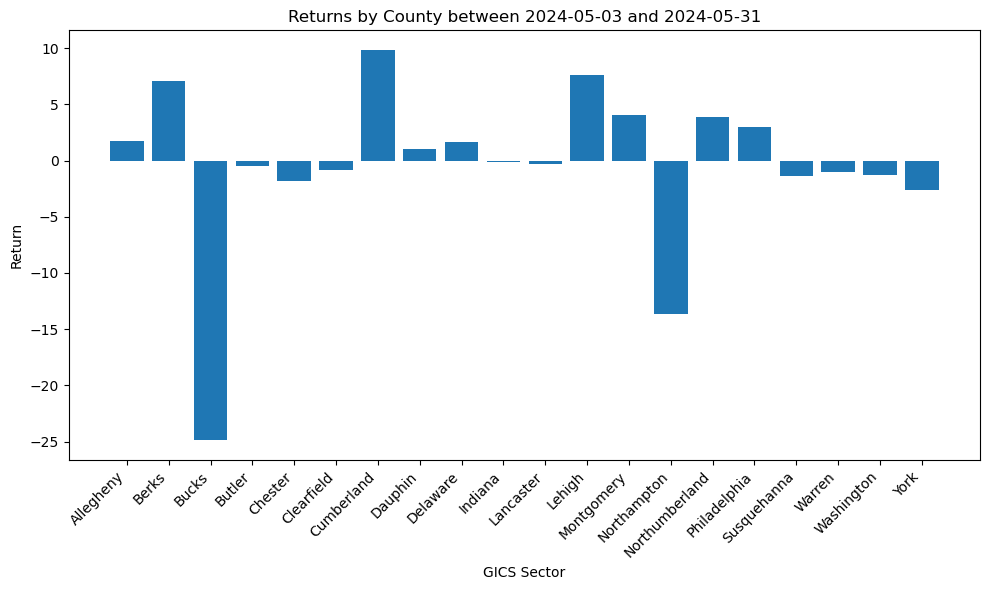

In [10]:
last_day = eod_market_cap_pivot['Date'].max()
first_day = eod_market_cap_pivot['Date'].min()
last_day_data = eod_market_cap_pivot[eod_market_cap_pivot['Date'] == last_day]

plt.figure(figsize=(10, 6))
plt.bar(last_day_data['County'], last_day_data['Return'])
plt.xlabel('GICS Sector')
plt.ylabel('Return')
plt.title(f'Returns by County between {first_day.date()} and {last_day.date()}')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [14]:
# file_path = 'output/county_output.xlsx'
# eod_market_cap_pivot.to_excel(file_path, index=False)